# Image Classification - Deep Learning

This notebook demonstrates training multiple models (RegNetY-032, ViT-Small, CSPDarkNet53) on the Oxford-IIIT Pet dataset with evaluation and export workflows.

**Note:** ViT-Small uses custom training configuration (`train_vit.yaml`) with lower learning rate and more epochs for full fine-tuning.

## 1. Environment Setup
Install dependencies (choose matching CUDA wheel if needed).

In [1]:
!git clone https://github.com/HenryNVP/image-classification.git
%cd image-classification

Cloning into 'image-classification'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 225 (delta 77), reused 190 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (225/225), 1.38 MiB | 56.65 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/image-classification


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


## 2. Download and Prepare Data
This downloads the official dataset and prepares 256x256 splits.

In [3]:
!python scripts/get_data.py
!python scripts/split_dataset.py

/content/image-classification/scripts/get_data.py:33: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(destination)
Prepared train=3680 val=1832 test=1837


## 3. Train Multiple Models
Train RegNetY-032, ViT-Small (with custom training config), and CSPDarkNet53 sequentially.

Each model uses optimized configurations:
- **RegNetY & CSPDarkNet**: Standard config with frozen backbone, batch_size=256, lr=5e-4
- **ViT-Small**: Custom config (`train_vit.yaml`) with unfrozen backbone, batch_size=256, lr=1e-4, 50 epochs

In [4]:
# Define models to train with their specific configs
# Format: (model_name, model_config, aug_config, train_config)
models = [
    ('regnety_032', 'configs/model/regnety_032.yaml', 'configs/aug.yaml', 'configs/train.yaml'),
    ('vit_small_patch16_224', 'configs/model/vit_small_patch16_224.yaml', 'configs/aug_vit.yaml', 'configs/train_vit.yaml'),
    ('cspdarknet53', 'configs/model/cspdarknet53.yaml', 'configs/aug.yaml', 'configs/train.yaml')
]

# Train each model
for model_name, model_config, aug_config, train_config in models:
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    !python train.py --model-config {model_config} --aug-config {aug_config} --train-config {train_config} --output-dir checkpoints/{model_name} --plot
    print(f"\nCompleted training {model_name}")


Training regnety_032

model.safetensors: 100% 78.1M/78.1M [00:02<00:00, 27.4MB/s]
/content/image-classification/src/engine.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
/content/image-classification/src/engine.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):
Epoch 1/20 Step 10/15 - loss: 3.4766 acc: 14.65%
Epoch 1/20 - train loss 3.3698 acc 22.96% - val loss 2.6675 acc 76.09% (best 76.09%)
Epoch 2/20 Step 10/15 - loss: 2.4878 acc: 69.34%
Epoch 2/20 - train loss 2.3007 acc 72.17% - val loss 0.8993 acc 87.06% (best 87.06%)
Epoch 3/20 Step 10/15 - loss: 1.4924 acc: 80.74%
Epoch 3/20 - train loss 1.4314 acc 81.30% - val loss 0.6532 acc 88.37% (best 88.37%)
Epoch 4/20 Step 10/15 - loss: 1.2016 acc: 83.79%
Epoch 4/2

## 4. Evaluate All Models
Test all trained models on the test split and compare results.

In [5]:
# Evaluate each model on test set
results = {}

for model_name, model_config, aug_config, train_config in models:
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}")
    print(f"{'='*60}\n")
    !python validate.py --model-config {model_config} --aug-config {aug_config} --checkpoint checkpoints/{model_name}/best.pth --split test --output checkpoints/{model_name}/test_metrics.json

print(f"\n{'='*60}")
print("Summary of Test Results")
print(f"{'='*60}\n")

# Display results summary
import json
from pathlib import Path

for model_name, _, _, _ in models:
    metrics_path = Path(f'checkpoints/{model_name}/test_metrics.json')
    if metrics_path.exists():
        with open(metrics_path) as f:
            metrics = json.load(f)
        print(f"{model_name:30s} - Accuracy: {metrics.get('accuracy', 0)*100:.2f}% | Loss: {metrics.get('loss', 0):.4f}")
    else:
        print(f"{model_name:30s} - Metrics not found")


Evaluating regnety_032

Split 'test' - Loss: 0.3986 Acc: 92.16% MacroP: 92.31% MacroR: 92.15% MacroF1: 92.03% ROC AUC: 99.85%
Saved metrics to checkpoints/regnety_032/test_metrics.json

Evaluating vit_small_patch16_224

Split 'test' - Loss: 0.5207 Acc: 88.62% MacroP: 89.16% MacroR: 88.57% MacroF1: 88.47% ROC AUC: 99.73%
Saved metrics to checkpoints/vit_small_patch16_224/test_metrics.json

Evaluating cspdarknet53

Split 'test' - Loss: 0.9022 Acc: 89.55% MacroP: 89.84% MacroR: 89.49% MacroF1: 89.33% ROC AUC: 99.67%
Saved metrics to checkpoints/cspdarknet53/test_metrics.json

Summary of Test Results

regnety_032                    - Accuracy: 92.16% | Loss: 0.3986
vit_small_patch16_224          - Accuracy: 88.62% | Loss: 0.5207
cspdarknet53                   - Accuracy: 89.55% | Loss: 0.9022


## 5. Compare Predictions Across Models
Visualize predictions from all three models on the same sample.

Sample index: 498
Ground truth: 10 (Siamese)

Model                          Top Prediction            Confidence Correct
regnety_032                    Siamese                    90.45%    ✓
vit_small_patch16_224          Siamese                    83.23%    ✓
cspdarknet53                   Siamese                    49.97%    ✓


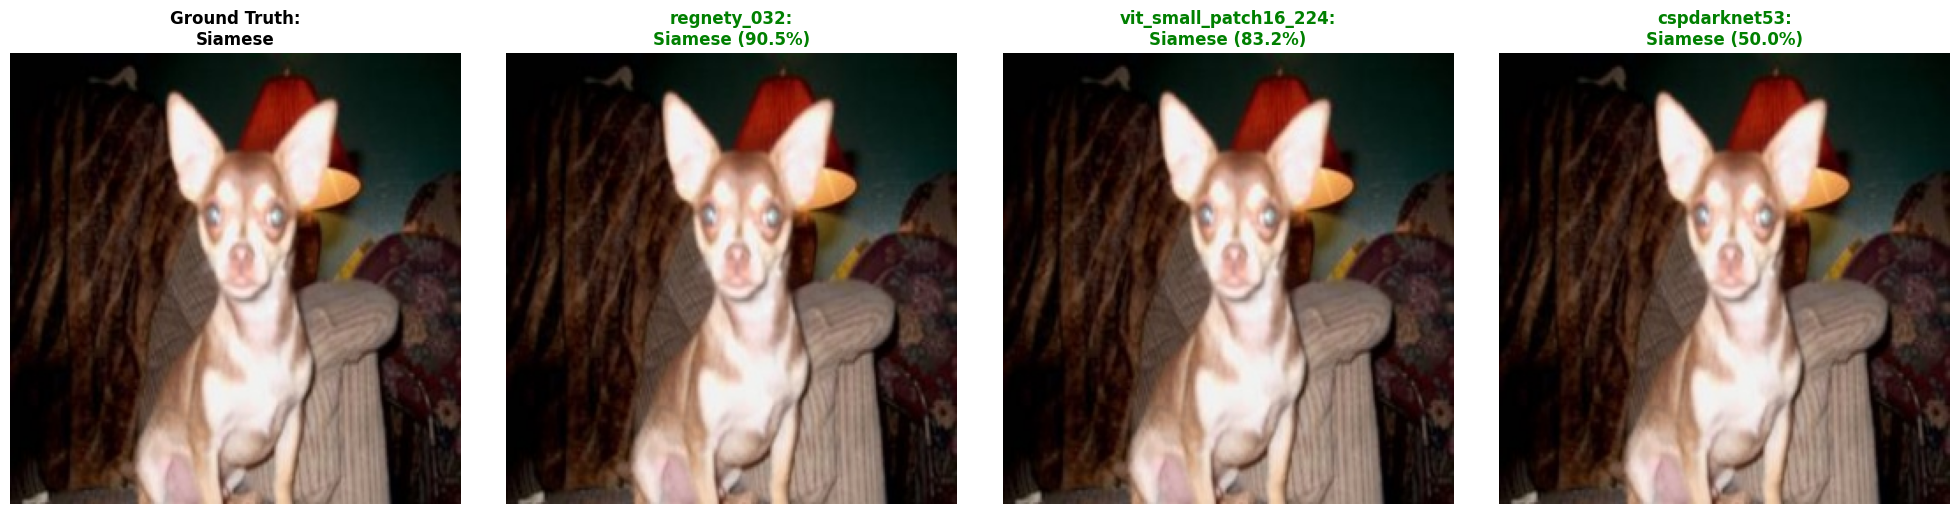

In [9]:
import torch
from pathlib import Path
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from src.config import load_configs, to_namespace
from src.data import ImageClassificationDataset
from src.models import create_model
from src.utils import get_device

device = torch.device(get_device())

# Load a reference dataset to get class names and pick a sample index
ref_dataset = ImageClassificationDataset('data/val', 'data/val_labels.csv', train=False)
class_names = ref_dataset.classes

# Pick a random sample index
idx = torch.randint(0, len(ref_dataset), ()).item()
sample_path = ref_dataset.samples[idx].path
label = ref_dataset.samples[idx].label

print(f'Sample index: {idx}')
print(f'Ground truth: {label} ({class_names[label]})')
print(f'\n{"Model":<30} {"Top Prediction":<25} {"Confidence":<10} {"Correct"}')
print('='*80)

# Load models and get predictions with model-specific transforms
predictions = {}
model_images = {}

for model_name, model_config, aug_config, train_config in models:
    # Load model
    cfg_paths = [
        Path(train_config),
        Path('configs/data.yaml'),
        Path(model_config),
        Path(aug_config),
    ]
    config = load_configs(cfg_paths)
    model_cfg = to_namespace(config['model'])

    model = create_model(model_cfg)
    checkpoint_path = f'checkpoints/{model_name}/best.pth'
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    model.to(device)

    # Create dataset with model-specific augmentation config
    model_dataset = ImageClassificationDataset(
        'data/val',
        'data/val_labels.csv',
        train=False,
        augment_config=config.get('augment')
    )

    # Get the preprocessed image for this model
    image, _ = model_dataset[idx]
    model_images[model_name] = image

    # Get prediction
    with torch.no_grad():
        logits = model(image.unsqueeze(0).to(device))
        prob = torch.softmax(logits, dim=1).squeeze(0)
        top_idx = prob.topk(1).indices.item()
        top_conf = prob.topk(1).values.item()
        predictions[model_name] = (top_idx, top_conf, prob)

        correct = "✓" if top_idx == label else "✗"
        print(f'{model_name:<30} {class_names[top_idx]:<25} {top_conf*100:>6.2f}%    {correct}')

# Visualize the image with all predictions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image (unnormalized for display)
original_img = Image.open(sample_path).convert('RGB')
axes[0].imshow(original_img)
axes[0].set_title(f"Ground Truth:\n{class_names[label]}", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Predictions from each model
for plot_idx, (model_name, (pred_idx, conf, prob)) in enumerate(predictions.items(), 1):
    # Use the original image for consistent visualization
    axes[plot_idx].imshow(original_img)
    color = 'green' if pred_idx == label else 'red'
    axes[plot_idx].set_title(f"{model_name}:\n{class_names[pred_idx]} ({conf*100:.1f}%)",
                        fontsize=12, color=color, fontweight='bold')
    axes[plot_idx].axis('off')

plt.tight_layout()
plt.show()

In [8]:
!pip install onnx onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 3.3 MB/s eta 0:00:00


In [11]:
# Export all models to TorchScript and ONNX
for model_name, model_config, aug_config, train_config in models:
    print(f"\n{'='*60}")
    print(f"Exporting {model_name}")
    print(f"{'='*60}\n")
    !python scripts/export_models.py \
      --model-config {model_config} \
      --aug-config {aug_config} \
      --checkpoint checkpoints/{model_name}/best.pth \
      --output-dir exports/{model_name}
    print(f"\nCompleted exporting {model_name}")



Exporting regnety_032

Saved TorchScript model to exports/regnety_032/model_scripted.pt
/content/image-classification/scripts/export_models.py:151: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
Saved ONNX model to exports/regnety_032/model.onnx

Completed exporting regnety_032

Exporting vit_small_patch16_224

Saved TorchScript model to exports/vit_small_patch16_224/model_scripted.pt
/content/image-classification/scripts/export_models.py:151

In [12]:
# Download exported models
!zip -r exports.zip exports
from google.colab import files
files.download('exports.zip')

  adding: exports/ (stored 0%)
  adding: exports/cspdarknet53/ (stored 0%)
  adding: exports/cspdarknet53/model.onnx (deflated 7%)
  adding: exports/cspdarknet53/model_scripted.pt (deflated 7%)
  adding: exports/vit_small_patch16_224/ (stored 0%)
  adding: exports/vit_small_patch16_224/model.onnx (deflated 7%)
  adding: exports/vit_small_patch16_224/model_scripted.pt (deflated 7%)
  adding: exports/regnety_032/ (stored 0%)
  adding: exports/regnety_032/model.onnx (deflated 7%)
  adding: exports/regnety_032/model_scripted.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Download checkpoints
!zip -r checkpoints.zip checkpoints
files.download('checkpoints.zip')

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/cspdarknet53/ (stored 0%)
  adding: checkpoints/cspdarknet53/test_metrics.json (deflated 80%)
  adding: checkpoints/cspdarknet53/best.pth (deflated 7%)
  adding: checkpoints/cspdarknet53/history.json (deflated 76%)
  adding: checkpoints/cspdarknet53/last.pt (deflated 7%)
  adding: checkpoints/cspdarknet53/training_curves.png (deflated 10%)
  adding: checkpoints/vit_small_patch16_224/ (stored 0%)
  adding: checkpoints/vit_small_patch16_224/test_metrics.json (deflated 81%)
  adding: checkpoints/vit_small_patch16_224/best.pth (deflated 7%)
  adding: checkpoints/vit_small_patch16_224/history.json (deflated 76%)
  adding: checkpoints/vit_small_patch16_224/last.pt (deflated 8%)
  adding: checkpoints/vit_small_patch16_224/training_curves.png (deflated 12%)
  adding: checkpoints/regnety_032/ (stored 0%)
  adding: checkpoints/regnety_032/test_metrics.json (deflated 82%)
  adding: checkpoints/regnety_032/best.pth (deflated 7%)
  adding: ch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Test TorchScript inference for all models
import torch

print(f'{"Model":<30} {"Format":<15} {"Prediction":<25} {"Confidence"}')
print('='*90)

# Use the same image and move it to the correct device
image = image.to(device)

for model_name, _, _, _ in models:
    scripted_model = torch.jit.load(f'exports/{model_name}/model_scripted.pt')
    scripted_model.eval()
    scripted_model.to(device)

    with torch.no_grad():
        scripted_logits = scripted_model(image.unsqueeze(0))
    scripted_prob = torch.softmax(scripted_logits, dim=1).squeeze(0)
    pred_idx = scripted_prob.topk(1).indices.item()
    pred_conf = scripted_prob.topk(1).values.item()

    print(f'{model_name:<30} {"TorchScript":<15} {class_names[pred_idx]:<25} {pred_conf*100:>6.2f}%')


Model                          Format          Prediction                Confidence
regnety_032                    TorchScript     Siamese                    89.01%
vit_small_patch16_224          TorchScript     Siamese                    90.09%
cspdarknet53                   TorchScript     Siamese                    72.48%


In [14]:
# Test ONNX inference for all models
import onnxruntime
import numpy as np
from torchvision import transforms

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Resize the image to the expected input size of the ONNX model
resize_transform = transforms.Resize((224, 224))
resized_image = resize_transform(image)

print(f'{"Model":<30} {"Format":<15} {"Prediction":<25} {"Confidence"}')
print('='*90)

for model_name, _, _, _ in models:
    ort_session = onnxruntime.InferenceSession(
        f'exports/{model_name}/model.onnx',
        providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
    )

    # ONNX Runtime expects NumPy arrays
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(resized_image.unsqueeze(0))}
    ort_outputs = ort_session.run(None, ort_inputs)

    # The output is a list, get the first element
    onnx_logits = torch.tensor(ort_outputs[0])
    onnx_prob = torch.softmax(onnx_logits, dim=1).squeeze(0)
    pred_idx = onnx_prob.topk(1).indices.item()
    pred_conf = onnx_prob.topk(1).values.item()

    print(f'{model_name:<30} {"ONNX":<15} {class_names[pred_idx]:<25} {pred_conf*100:>6.2f}%')

Model                          Format          Prediction                Confidence
regnety_032                    ONNX            Siamese                    91.23%
vit_small_patch16_224          ONNX            Siamese                    82.65%
cspdarknet53                   ONNX            Siamese                    72.87%


In [16]:
# Run comprehensive benchmark script for all models
for model_name, model_config, aug_config, train_config in models:
    print(f"\n{'='*60}")
    print(f"Comprehensive Benchmark: {model_name}")
    print(f"{'='*60}\n")
    !python scripts/benchmark_models.py \
      --model-config {model_config} \
      --aug-config {aug_config} \
      --checkpoint checkpoints/{model_name}/best.pth \
      --torchscript exports/{model_name}/model_scripted.pt \
      --onnx exports/{model_name}/model.onnx \
      --device cuda --warmup 10 --runs 100 --batch-size 1



Comprehensive Benchmark: regnety_032

--- Benchmark Results ---
pytorch: FPS=75.48 Latency=13.25ms Total=1.325s
torchscript: FPS=134.47 Latency=7.44ms Total=0.744s
onnx: FPS=299.26 Latency=3.34ms Total=0.334s

Comprehensive Benchmark: vit_small_patch16_224

2025-10-25 03:58:04.089621272 [W:onnxruntime:, transformer_memcpy.cc:111 ApplyImpl] 12 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
--- Benchmark Results ---
pytorch: FPS=185.89 Latency=5.38ms Total=0.538s
torchscript: FPS=330.86 Latency=3.02ms Total=0.302s
onnx: FPS=392.07 Latency=2.55ms Total=0.255s

Comprehensive Benchmark: cspdarknet53

--- Benchmark Results ---
pytorch: FPS=110.43 Latency=9.06ms Total=0.906s
torchscript: FPS=214.76 Latency=4.66ms Total=0.466s
onnx: FPS=400.97 Latency=2.49ms Total=0.249s


## 6. Final Summary and Comparison

Compare all models across metrics, inference formats, and performance.


| Metric | vit_small_patch16_224 | cspdarknet53 | regnety_032 |
|---------|----------------------:|--------------:|-------------:|
| Test Accuracy (%) | 88.6228 | 89.5482 | 92.1611 |
| **TorchScript FPS** | **210.6438** | **103.3793** | **41.1488** |
| ONNX FPS | 327.2237 | 265.8467 | 193.1415 |
| TorchScript Latency (ms) | 4.7474 | 9.6731 | 24.3021 |
| ONNX Latency (ms) | 3.0560 | 3.7616 | 5.1776 |

**Conclusions**:
- RegNetY-032 achieves the highest accuracy; however it is the slowest model.
- ViT-Small Patch16 224 has slightly lower accuracy but significantly faster.
- CSPDarkNet53 has good trade-off between accuracy and speed.